# Predict Future Sales

## Imports

In [1]:
import pandas as pd
pd.set_option('float_format', '{0:.2f}'.format)

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

## Import data

In [3]:
train = pd.read_csv("data/sales_train.csv")
items = pd.read_csv("data/items.csv")
categories = pd.read_csv("data/item_categories.csv")
shops = pd.read_csv("data/shops.csv")
test = pd.read_csv("data/test.csv")

## Initial preparations

In [4]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[["shop_id", "city_code"]]

In [5]:
categories['split'] = categories['item_category_name'].str.split('-')
categories['cat'] = categories['split'].map(lambda x: x[0].strip())
categories['cat_code'] = LabelEncoder().fit_transform(categories['cat'])
# if subcategory is nan then category
categories['subcat'] = categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
categories['subcat_code'] = LabelEncoder().fit_transform(categories['subcat'])
categories = categories[["item_category_id", "cat_code", "subcat_code"]]

In [5]:
validation = train[train.date_block_num==33]

In [6]:
full_data = pd.merge(train, items, on=["item_id"], how='left')
full_data = pd.merge(full_data, categories, on="item_category_id", how='left')
full_data = pd.merge(full_data, shops, on="shop_id", how='left')

In [7]:
df = full_data.copy()

In [8]:
df["date"] = pd.to_datetime(df["date"], format='%d.%m.%Y')
df["day"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year
df["month_year"] = df["date"].dt.strftime('%Y-%m')
df["month_year"] = pd.to_datetime(df["month_year"])

In [9]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

df = downcast_dtypes(df)

## Exploration

In [13]:
df.drop(columns=["item_name"], inplace=True)
df.rename(columns={'item_cnt_day' : 'item_volume'}, inplace=True)
df["revenue"] = df["item_volume"] * df["item_price"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2882335 entries, 0 to 2882334
Data columns (total 15 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   date_block_num    int16         
 2   shop_id           int16         
 3   item_id           int16         
 4   item_price        float32       
 5   item_volume       float32       
 6   item_category_id  int16         
 7   cat_code          int16         
 8   subcat_code       int16         
 9   city_code         int16         
 10  day               int16         
 11  month             int16         
 12  year              int16         
 13  month_year        datetime64[ns]
 14  revenue           float32       
dtypes: datetime64[ns](2), float32(3), int16(10)
memory usage: 153.9 MB


In [14]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_volume,item_category_id,cat_code,subcat_code,city_code,day,month,year,month_year,revenue
0,2013-01-02,0,59,22154,999.000,1.000,37,11,1,31,2,1,2013,2013-01-01,999.000
1,2013-01-03,0,25,2552,899.000,1.000,58,13,27,14,3,1,2013,2013-01-01,899.000
2,2013-01-05,0,25,2552,899.000,-1.000,58,13,27,14,5,1,2013,2013-01-01,-899.000
3,2013-01-06,0,25,2554,1709.050,1.000,58,13,27,14,6,1,2013,2013-01-01,1709.050
4,2013-01-15,0,25,2555,1099.000,1.000,56,13,3,14,15,1,2013,2013-01-01,1099.000


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2882335.000,14.228,9.166,0.000,6.000,13.000,22.000,32.000
shop_id,2882335.000,33.028,16.228,0.000,22.000,31.000,47.000,59.000
item_id,2882335.000,10186.036,6326.743,0.000,4466.000,9250.000,15693.000,22169.000
item_price,2882335.000,884.657,1715.958,-1.000,249.000,399.000,999.000,307980.000
item_volume,2882335.000,1.241,2.283,-22.000,1.000,1.000,1.000,1000.000
item_category_id,2882335.000,39.959,17.077,0.000,28.000,40.000,55.000,83.000
cat_code,2882335.000,9.866,3.496,0.000,8.000,11.000,13.000,19.000
subcat_code,2882335.000,20.932,20.805,0.000,4.000,11.000,41.000,64.000
city_code,2882335.000,17.022,7.600,0.000,14.000,14.000,23.000,31.000
day,2882335.000,15.852,8.918,1.000,8.000,16.000,24.000,31.000


In [16]:
df[df.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_volume,item_category_id,cat_code,subcat_code,city_code,day,month,year,month_year,revenue
484683,2013-05-15,4,32,2973,-1.000,1.000,19,5,10,14,15,5,2013,2013-05-01,-1.000


In [17]:
df[(df.item_id==2973) & (df.shop_id==32)]

,date,date_block_num,shop_id,item_id,item_price,item_volume,item_category_id,cat_code,subcat_code,city_code,day,month,year,month_year,revenue
67427,2013-01-29,0,32,2973,2499.000,1.000,19,5,10,14,29,1,2013,2013-01-01,2499.000
67428,2013-01-25,0,32,2973,2499.000,1.000,19,5,10,14,25,1,2013,2013-01-01,2499.000
67429,2013-01-22,0,32,2973,2499.000,1.000,19,5,10,14,22,1,2013,2013-01-01,2499.000
67430,2013-01-21,0,32,2973,2499.000,1.000,19,5,10,14,21,1,2013,2013-01-01,2499.000
67431,2013-01-18,0,32,2973,2499.000,1.000,19,5,10,14,18,1,2013,2013-01-01,2499.000
67432,2013-01-17,0,32,2973,2499.000,1.000,19,5,10,14,17,1,2013,2013-01-01,2499.000
67433,2013-01-15,0,32,2973,2499.000,3.000,19,5,10,14,15,1,2013,2013-01-01,7497.000
187844,2013-02-05,1,32,2973,2499.000,1.000,19,5,10,14,5,2,2013,2013-02-01,2499.000
187845,2013-02-14,1,32,2973,2499.000,1.000,19,5,10,14,14,2,2013,2013-02-01,2499.000
484682,2013-05-23,4,32,2973,1249.000,1.000,19,5,10,14,23,5,2013,2013-05-01,1249.000


In [31]:
#TODO Replace negative or null values by median of item_price for same year and same shop and same item

### Remove outliers

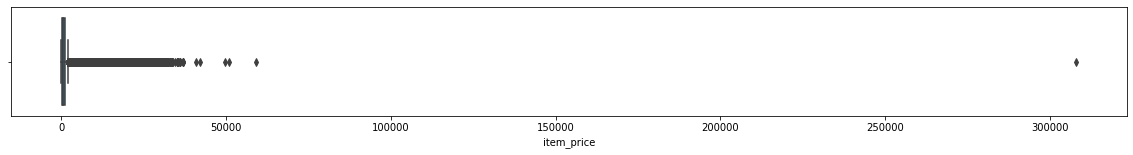

In [18]:
plt.figure(figsize=(20,2))
sns.boxplot(df.item_price)

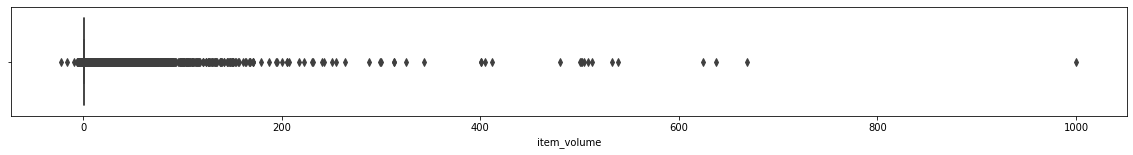

In [19]:
plt.figure(figsize=(20,2))
sns.boxplot(df.item_volume)

In [20]:
# Remove outliers
df = df[df.item_price < 100000]
df = df[df.item_volume < 100]

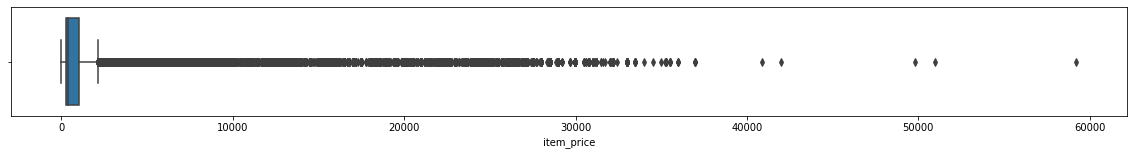

In [21]:
plt.figure(figsize=(20,2))
sns.boxplot(df.item_price)

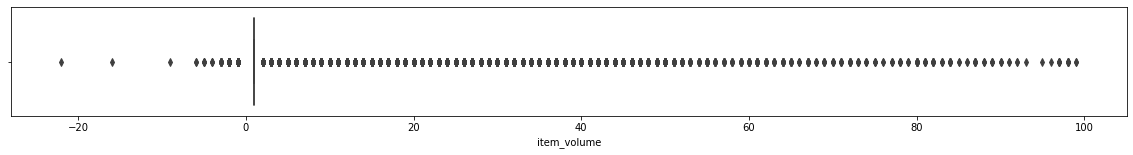

In [22]:
plt.figure(figsize=(20,2))
sns.boxplot(df.item_volume)

### Time series analysis

In [23]:
gp = df.groupby(["month_year","shop_id", "item_id"]).agg({'item_volume' : 'sum', 'item_price' : 'mean'}).reset_index()

In [24]:
gp.head()

,month_year,shop_id,item_id,item_volume,item_price
0,2013-01-01,0,32,6.000,221.000
1,2013-01-01,0,33,3.000,347.000
2,2013-01-01,0,35,1.000,247.000
3,2013-01-01,0,43,1.000,221.000
4,2013-01-01,0,51,2.000,128.500


In [25]:
gp.describe().T

,count,mean,std,min,25%,50%,75%,max
shop_id,1577587.000,32.829,16.537,0.000,21.000,31.000,47.000,59.000
item_id,1577587.000,10676.665,6240.264,0.000,5045.000,10491.000,16069.000,22169.000
item_volume,1577587.000,2.249,7.583,-22.000,1.000,1.000,2.000,1305.000
item_price,1577587.000,783.114,1507.078,0.090,199.000,398.500,850.000,50999.000


In [26]:
gp_month = gp.groupby(["month_year"]).agg({'item_volume': 'sum'}).reset_index()

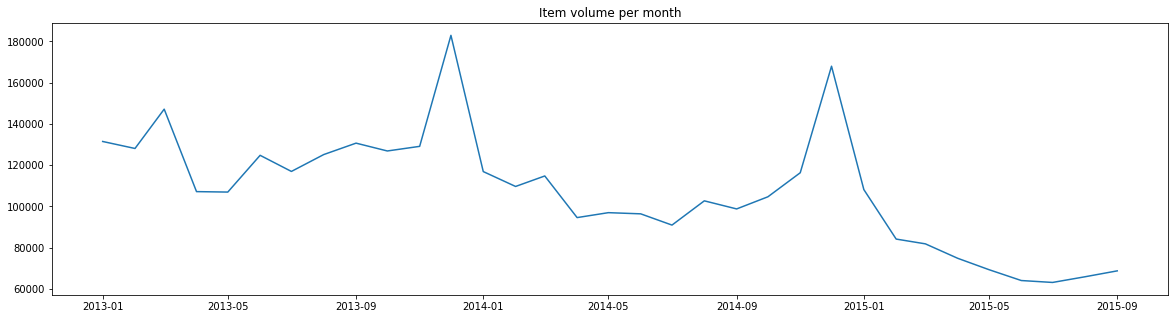

In [27]:
plt.figure(figsize=(20,5))
plt.plot(gp_month.month_year, gp_month.item_volume)
plt.title("Item volume per month")
plt.show()

In [28]:
gp_nb_items = gp.groupby(["month_year"]).agg({'item_id' : 'nunique'})

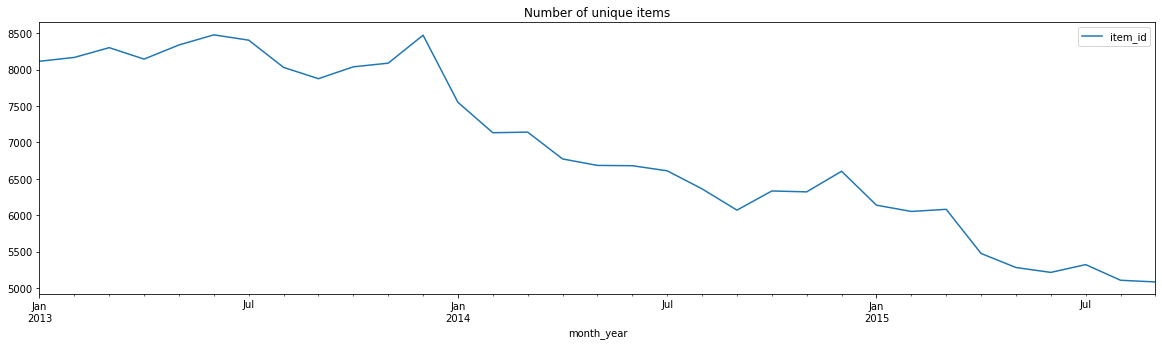

In [43]:
gp_nb_items.plot(figsize=(20,5))
plt.title("Number of unique items")
plt.show()

### Shops KPIs

In [44]:
gp_shops = df.groupby(["month_year", "shop_id"]).agg({'item_volume' : 'sum', 'revenue' : 'sum'}).reset_index()

In [45]:
gp_shops

,month_year,shop_id,item_volume,revenue
0,2013-01-01,0,5578.000,2966412.000
1,2013-01-01,1,2947.000,1527320.000
2,2013-01-01,2,1146.000,1085064.750
3,2013-01-01,3,767.000,560585.000
4,2013-01-01,4,2114.000,1433666.000
...,...,...,...,...
1537,2015-09-01,55,4711.000,5356952.000
1538,2015-09-01,56,1194.000,1345430.000
1539,2015-09-01,57,2266.000,2134761.000
1540,2015-09-01,58,1319.000,1522606.000


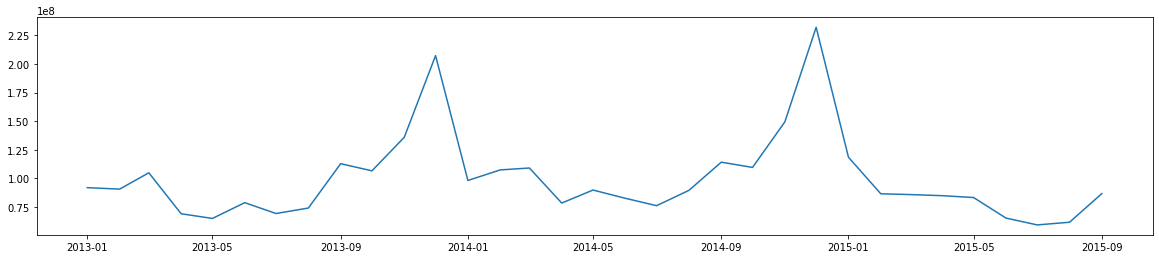

In [46]:
gp_month_shops = gp_shops.groupby("month_year").sum().reset_index()
plt.figure(figsize=(20,4))
plt.plot(gp_month_shops.month_year, gp_month_shops.revenue)
plt.show()

In [47]:
gp_month_shops

,month_year,shop_id,item_volume,revenue
0,2013-01-01,1259,131479.000,91947088.000
1,2013-02-01,1264,128090.000,90665704.000
2,2013-03-01,1378,147142.000,104932688.000
3,2013-04-01,1378,107190.000,69154288.000
4,2013-05-01,1402,106970.000,65065312.000
5,2013-06-01,1419,124774.000,78837112.000
6,2013-07-01,1419,116966.000,69350600.000
7,2013-08-01,1387,125141.000,74148120.000
8,2013-09-01,1387,130674.000,112864440.000
9,2013-10-01,1396,126880.000,106647912.000
